In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Skripsi

/content/drive/MyDrive/Skripsi


In [ ]:
import numpy as np
import pandas as pd
import datetime
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import os
import utils.time_series_processing as tsp
import utils.visualisation as vs

In [ ]:
print(tf.__version__)

2.19.0


## Prepare dataset

In [ ]:
TICKER = "TLKM"
SEQ_LEN = 60
PRED_HORIZON = 22
VAL_SPLIT = 0.2
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
df = pd.read_csv(
    f"./data/{TICKER}/data_integrasi_{TICKER}.csv",
    index_col=0,
    parse_dates=[0],
    date_format="%Y-%m-%d"
    )
df

,Close,High,Low,Open,Volume,nilai_sentimen
tanggal,,,,,,
2022-07-11,3386.848145,3437.147869,3353.314995,3437.147869,42258000,-0.234899
2022-07-12,3361.698242,3403.614679,3361.698242,3403.614679,43399800,-0.116959
2022-07-13,3303.015137,3378.464721,3294.631850,3361.698147,96218200,-0.230263
2022-07-14,3370.081543,3370.081543,3269.482094,3303.015244,68708500,-0.182482
2022-07-15,3479.064209,3529.363932,3361.698187,3386.848049,146093800,-0.158824
...,...,...,...,...,...,...
2025-07-25,2820.000000,2830.000000,2780.000000,2810.000000,41296200,-0.066406
2025-07-28,2860.000000,2870.000000,2830.000000,2870.000000,40193800,-0.036199
2025-07-29,2880.000000,2880.000000,2840.000000,2870.000000,46357400,-0.192308


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2022-07-11 to 2025-07-31
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           732 non-null    float64
 1   High            732 non-null    float64
 2   Low             732 non-null    float64
 3   Open            732 non-null    float64
 4   Volume          732 non-null    int64  
 5   nilai_sentimen  732 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 40.0 KB


In [ ]:
df = df.sort_index()
df.index = pd.to_datetime(df.index)
df

,Close,High,Low,Open,Volume,nilai_sentimen
tanggal,,,,,,
2022-07-11,3386.848145,3437.147869,3353.314995,3437.147869,42258000,-0.234899
2022-07-12,3361.698242,3403.614679,3361.698242,3403.614679,43399800,-0.116959
2022-07-13,3303.015137,3378.464721,3294.631850,3361.698147,96218200,-0.230263
2022-07-14,3370.081543,3370.081543,3269.482094,3303.015244,68708500,-0.182482
2022-07-15,3479.064209,3529.363932,3361.698187,3386.848049,146093800,-0.158824
...,...,...,...,...,...,...
2025-07-25,2820.000000,2830.000000,2780.000000,2810.000000,41296200,-0.066406
2025-07-28,2860.000000,2870.000000,2830.000000,2870.000000,40193800,-0.036199
2025-07-29,2880.000000,2880.000000,2840.000000,2870.000000,46357400,-0.192308


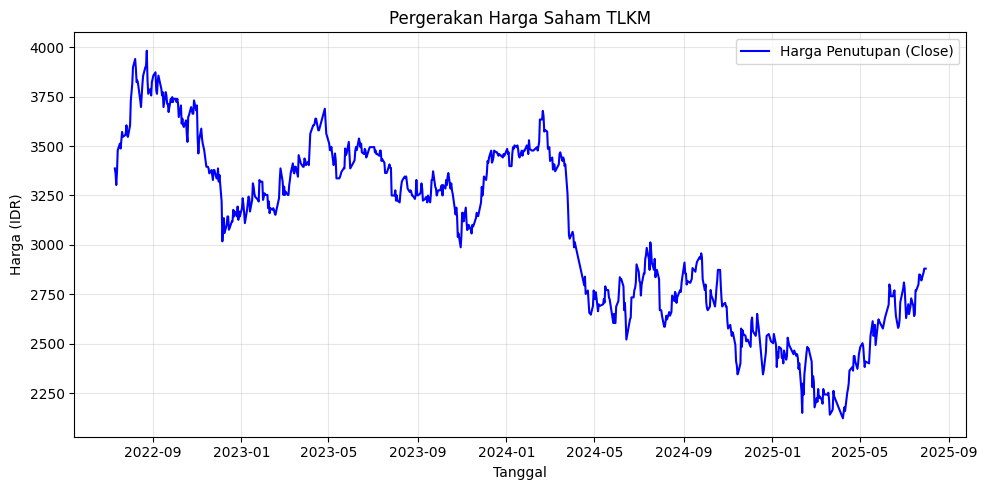

In [ ]:
vs.plot_data(df, TICKER)

In [ ]:
df = df[["Close", "Volume", "nilai_sentimen"]]
df

,Close,Volume,nilai_sentimen
tanggal,,,
2022-07-11,3386.848145,42258000,-0.234899
2022-07-12,3361.698242,43399800,-0.116959
2022-07-13,3303.015137,96218200,-0.230263
2022-07-14,3370.081543,68708500,-0.182482
2022-07-15,3479.064209,146093800,-0.158824
...,...,...,...
2025-07-25,2820.000000,41296200,-0.066406
2025-07-28,2860.000000,40193800,-0.036199
2025-07-29,2880.000000,46357400,-0.192308


In [ ]:
scaler, data_scaled, X_all, y_all, X_train, y_train, X_val, y_val, train_dates, val_dates = tsp.prepare_data_time_series(df)

In [ ]:
print("Train samples:", X_train.shape[0], "val samples:", X_val.shape[0])

Train samples: 520 val samples: 131


In [ ]:
last_date = df.index[-1]
future_dates = pd.bdate_range(start=last_date + datetime.timedelta(days=1), periods=PRED_HORIZON)
#future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=PRED_HORIZON, freq='B')
last_seq = data_scaled[-SEQ_LEN:]

## Ensemble

In [ ]:
lstm_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_lstm_model.keras")
bilstm_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_bilstm_model.keras")
gru_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_gru_model.keras")

In [ ]:
model_names = ["LSTM", "BiLSTM", "GRU"]
models = [lstm_model, bilstm_model, gru_model]

In [ ]:
individual_predictions_train = {}

for name, model in zip(model_names, models):
    pred = model.predict(X_train)
    individual_predictions_train[name] = pred

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


In [ ]:
print(individual_predictions_train.keys())

dict_keys(['LSTM', 'BiLSTM', 'GRU'])


In [ ]:
print(individual_predictions_train)

{'LSTM': array([[0.7988218 , 0.78516823, 0.7999855 , ..., 0.75449044, 0.7616444 ,
        0.757464  ],
       [0.8069667 , 0.7945243 , 0.8077705 , ..., 0.7682405 , 0.77634746,
        0.7724833 ],
       [0.81355757, 0.80350554, 0.81393504, ..., 0.7811139 , 0.78816634,
        0.78414255],
       ...,
       [0.16967484, 0.17086473, 0.17248763, ..., 0.17037787, 0.16787285,
        0.17551592],
       [0.17614853, 0.1794608 , 0.17970887, ..., 0.17805368, 0.17786637,
        0.18418074],
       [0.18213952, 0.18780568, 0.18620041, ..., 0.1854322 , 0.18647537,
        0.19121632]], dtype=float32), 'BiLSTM': array([[0.8749572 , 0.86723113, 0.8673052 , ..., 0.8205381 , 0.81557894,
        0.8089092 ],
       [0.8886898 , 0.8807481 , 0.88040197, ..., 0.8227298 , 0.81865054,
        0.81001794],
       [0.91433156, 0.90461475, 0.90359426, ..., 0.81890345, 0.8143673 ,
        0.8033445 ],
       ...,
       [0.13334814, 0.12525582, 0.11817326, ..., 0.12240661, 0.12719116,
        0.13029653],


In [ ]:
individual_predictions_val = {}

for name, model in zip(model_names, models):
    pred = model.predict(X_val)
    individual_predictions_val[name] = pred

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [ ]:
print(individual_predictions_val.keys())

dict_keys(['LSTM', 'BiLSTM', 'GRU'])


In [ ]:
train_preds = list(individual_predictions_train.values())
val_preds = list(individual_predictions_val.values())

X_stack_train = np.stack(train_preds, axis=2)
X_stack_train = X_stack_train.reshape(X_stack_train.shape[0], -1)
X_stack_val = np.stack(val_preds, axis=2)
X_stack_val = X_stack_val.reshape(X_stack_val.shape[0], -1)

In [ ]:
print(train_preds[1])

[[0.8749572  0.86723113 0.8673052  ... 0.8205381  0.81557894 0.8089092 ]
 [0.8886898  0.8807481  0.88040197 ... 0.8227298  0.81865054 0.81001794]
 [0.91433156 0.90461475 0.90359426 ... 0.81890345 0.8143673  0.8033445 ]
 ...
 [0.13334814 0.12525582 0.11817326 ... 0.12240661 0.12719116 0.13029653]
 [0.14975706 0.1467496  0.14747962 ... 0.16155455 0.1623214  0.16154814]
 [0.16720271 0.16488896 0.16945556 ... 0.1842022  0.1878418  0.1841596 ]]


In [ ]:
meta_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(22, activation='linear', input_shape=(66,))
])

meta_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping based on validation loss
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = meta_model.fit(
    X_stack_train, y_train,
    validation_data=(X_stack_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8826 - mae: 0.7056 - val_loss: 0.0431 - val_mae: 0.1384
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2858 - mae: 0.3266 - val_loss: 0.0164 - val_mae: 0.0888
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0880 - mae: 0.1671 - val_loss: 0.0083 - val_mae: 0.0698
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0265 - mae: 0.0959 - val_loss: 0.0059 - val_mae: 0.0618
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094 - mae: 0.0687 - val_loss: 0.0052 - val_mae: 0.0583
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - mae: 0.0569 - val_loss: 0.0051 - val_mae: 0.0575
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047 - mae: 0.0534 - val_loss: 0.0051 - val_mae: 0.0573
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0046 - mae: 0.0528 - val_loss: 0.0051 - val_mae: 0.0573
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - mae:

In [ ]:
# prediksi menggunakan meta model
ensemble_preds_hist_train = meta_model.predict(X_stack_train)
ensemble_preds_hist_val = meta_model.predict(X_stack_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
future_predictions_base = tsp.predict_ensemble(
    models, scaler, last_seq, meta_model)

print(future_predictions_base[0])

[2847.94328862 2918.02048607 2904.882989   2938.87763061 2922.58590413
 2900.92857994 2906.45680679 2959.78004533 2879.88010376 2970.64428082
 2957.062338   2940.97790134 2966.97711858 2980.356149   2974.7040802
 3016.69165271 2977.56928966 2971.85554924 2957.67295914 3006.42390874
 2987.34643113 2967.58812758]


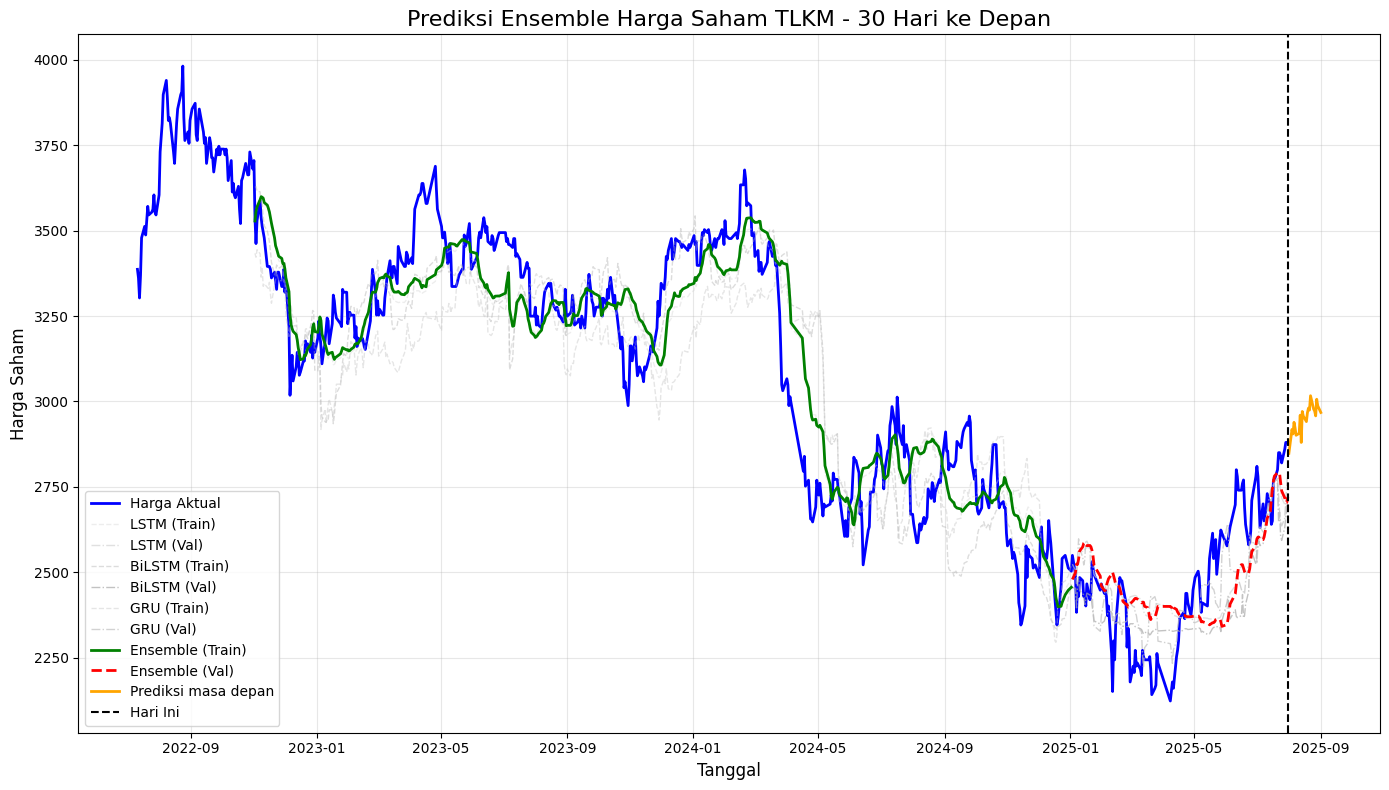

In [ ]:
vs.plot_ensemble_predictions(
    df, scaler, train_dates, val_dates, individual_predictions_train,
    individual_predictions_val, ensemble_preds_hist_train, ensemble_preds_hist_val,
    future_dates, future_predictions_base[0], TICKER
)

In [ ]:
# Menampilkan hasil prediksi masa depan dalam bentuk DataFrame
df_prediksi_masa_depan = pd.DataFrame({
    'Tanggal': future_dates,
    'Prediksi Harga': future_predictions_base[0].flatten()
})
df_prediksi_masa_depan.set_index('Tanggal', inplace=True)
df_prediksi_masa_depan


,Prediksi Harga
Tanggal,
2025-08-01,2847.943289
2025-08-04,2918.020486
2025-08-05,2904.882989
2025-08-06,2938.877631
2025-08-07,2922.585904
2025-08-08,2900.928580
2025-08-11,2906.456807
2025-08-12,2959.780045
2025-08-13,2879.880104


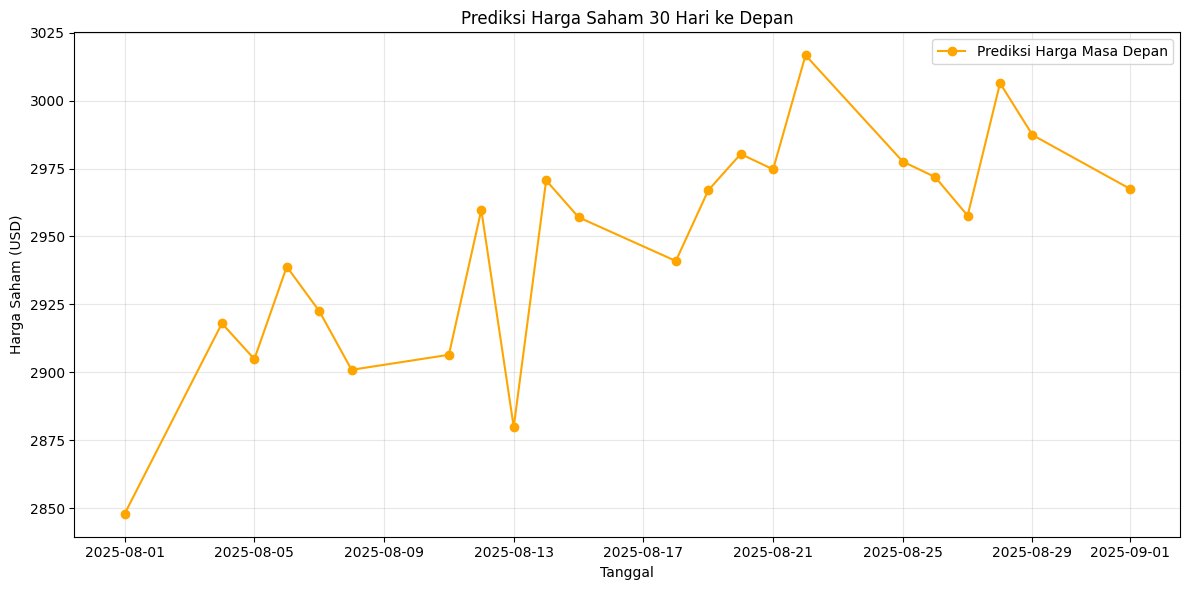

In [ ]:
vs.plot_future_predictions(future_dates, future_predictions_base[0])

In [ ]:
print(f"Evaluasi hasil prediksi pada Data Validasi:")
tsp.model_evaluate(y_val, ensemble_preds_hist_val)

Evaluasi hasil prediksi pada Data Validasi:
MAE  : 0.0541
MAPE : 8907928.9270%
MSE  : 0.0045
RMSE : 0.0667
R2   : 0.5324


In [ ]:
y_val_inv = inverse_scaler(y_val)
ensemble_preds_hist_val_inv = inverse_scaler(ensemble_preds_hist_val)

print(f"Evaluasi hasil prediksi pada Data Validasi:")
tsp.model_evaluate(y_val_inv, ensemble_preds_hist_val_inv)

Evaluasi hasil prediksi pada Data Validasi:
MAE  : 100.6611
MAPE : 4.1471%
MSE  : 15391.0870
RMSE : 124.0608
R2   : 0.5251


In [ ]:
meta_model.save(f"./model/{TICKER}/meta_model.keras")
meta_model.save(f"./model/{TICKER}/meta_model.h5")